# Skapa 2 modeller per ticker   
1. En modell som använder tomorrows close som target  
2. En modell som använder after tomorrows close som target   

In [59]:
from xgboost import XGBClassifier
from pytrends.request import TrendReq
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import pickle
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
plt.style.use('fivethirtyeight')
pd.set_option('display.width', 200)
import streamlit as st


In [62]:
# print pandas version
print('pandas version: {}'.format(pd.__version__))
# print numpy version
print('numpy version: {}'.format(np.__version__))
# print matplotlib version
print('matplotlib version: {}'.format(plt.matplotlib.__version__))
# print yfinance version
print('yfinance version: {}'.format(yf.__version__))
# print pickle version
print('pickle version: {}'.format(pickle.format_version))

import ta
# print ta version
print('ta version: {}'.format(ta.__version__))
'0.10.2'
# print streamlit version
print('streamlit version: {}'.format(st.__version__))

import xgboost
print('xgboost version: {}'.format(xgboost.__version__))



pandas version: 1.4.3
numpy version: 1.22.3
matplotlib version: 3.5.2
yfinance version: 0.1.72
pickle version: 4.0
ta version: 0.5.25
streamlit version: 1.10.0
xgboost version: 1.6.1


In [314]:
tickers = ['BTC-USD','ETH-USD','BCH-USD','ZRX-USD','XRP-USD']
ticker_names = ['Bitcoin','Ethereum','Bitcoin Cash','0X','Ripple']

In [315]:
# fill up a dataframe with all dates from 2015 up to today
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


## get Google Trends Bitcoin data


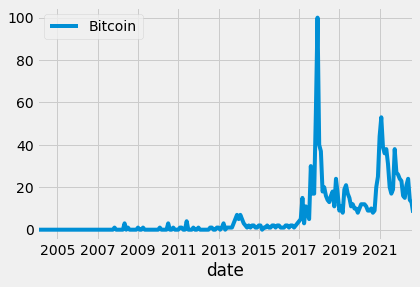

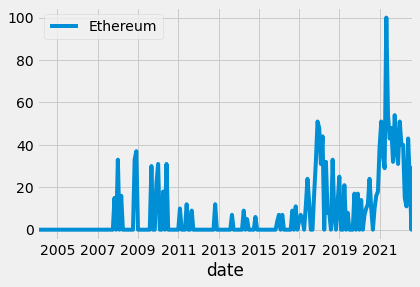

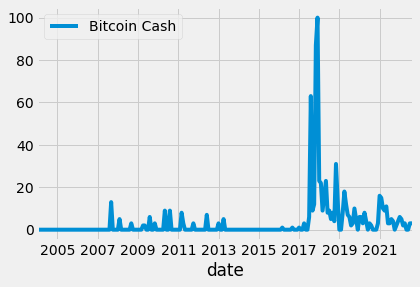

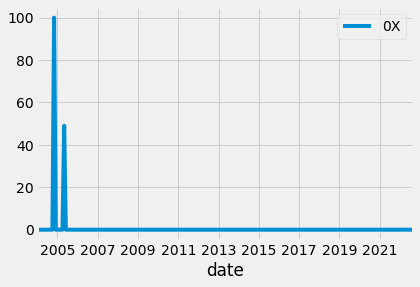

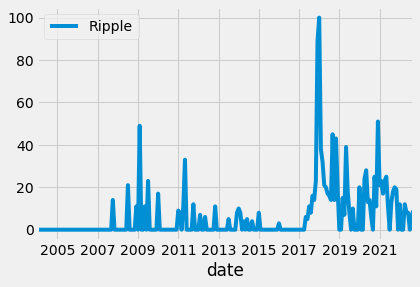

In [316]:
# get google trends data
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)
df_trend = get_all_dates()
for ticker_name in ticker_names:
    pytrends.build_payload(kw_list=[ticker_name],cat=7, timeframe='all', gprop='news')
    df_temp = pytrends.interest_over_time()
    # df_temp = df_temp.drop(columns=['isPartial'])
    df_temp.plot()
    df_trend = df_trend.merge(df_temp, how='left', left_index=True, right_index=True)
    df_trend[ticker_name] = df_trend[ticker_name].fillna(method='ffill')/30
    df_trend[ticker_name+'_30'] = df_trend[ticker_name].rolling(30, 1).mean()
    df_trend[ticker_name+'_90'] = df_trend[ticker_name].rolling(90, 1).mean()
    df_trend[ticker_name+'_250'] = df_trend[ticker_name].rolling(250, 1).mean()
    
df_trend = df_trend[ticker_names + [ticker_name+'_30' for ticker_name in ticker_names] + [ticker_name+'_90' for ticker_name in ticker_names] + [ticker_name+'_250' for ticker_name in ticker_names]]


In [317]:
df_trend.to_csv('google_trends.csv')
df_trend.tail()


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2022-09-24,0.267,1.0,0.1,0.0,0.3,0.300,0.800,0.1,0.0,0.280,0.417,0.594,0.096,0.0,0.161,0.577,0.878,0.085,0.0,0.189
2022-09-25,0.267,1.0,0.1,0.0,0.3,0.294,0.833,0.1,0.0,0.283,0.411,0.590,0.097,0.0,0.161,0.575,0.876,0.084,0.0,0.189
2022-09-26,0.267,1.0,0.1,0.0,0.3,0.289,0.867,0.1,0.0,0.287,0.405,0.585,0.098,0.0,0.161,0.573,0.873,0.084,0.0,0.188
2022-09-27,0.267,1.0,0.1,0.0,0.3,0.283,0.900,0.1,0.0,0.290,0.399,0.580,0.099,0.0,0.162,0.570,0.870,0.083,0.0,0.188
2022-09-28,0.267,1.0,0.1,0.0,0.3,0.278,0.933,0.1,0.0,0.293,0.393,0.575,0.100,0.0,0.162,0.568,0.867,0.083,0.0,0.187


## skapa alla modellerna

In [318]:
df_trend.query('index>"2017-01-01"').head(35)

,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2017-01-02,0.133,0.133,0.033,0.0,0.0,0.102,0.009,0.002,0.0,0.0,0.070,0.125,7.407e-04,0.0,0.0,0.063,0.081,0.004,0.0,0.0
2017-01-03,0.133,0.133,0.033,0.0,0.0,0.103,0.013,0.003,0.0,0.0,0.071,0.127,1.111e-03,0.0,0.0,0.063,0.082,0.004,0.0,0.0
2017-01-04,0.133,0.133,0.033,0.0,0.0,0.104,0.018,0.004,0.0,0.0,0.072,0.128,1.481e-03,0.0,0.0,0.063,0.082,0.005,0.0,0.0
2017-01-05,0.133,0.133,0.033,0.0,0.0,0.106,0.022,0.006,0.0,0.0,0.073,0.130,1.852e-03,0.0,0.0,0.064,0.083,0.005,0.0,0.0
2017-01-06,0.133,0.133,0.033,0.0,0.0,0.107,0.027,0.007,0.0,0.0,0.074,0.131,2.222e-03,0.0,0.0,0.064,0.083,0.005,0.0,0.0
2017-01-07,0.133,0.133,0.033,0.0,0.0,0.108,0.031,0.008,0.0,0.0,0.075,0.133,2.593e-03,0.0,0.0,0.064,0.084,0.005,0.0,0.0
2017-01-08,0.133,0.133,0.033,0.0,0.0,0.109,0.036,0.009,0.0,0.0,0.076,0.134,2.963e-03,0.0,0.0,0.065,0.084,0.005,0.0,0.0
2017-01-09,0.133,0.133,0.033,0.0,0.0,0.110,0.040,0.010,0.0,0.0,0.077,0.136,3.333e-03,0.0,0.0,0.065,0.085,0.005,0.0,0.0
2017-01-10,0.133,0.133,0.033,0.0,0.0,0.111,0.044,0.011,0.0,0.0,0.079,0.137,3.704e-03,0.0,0.0,0.065,0.085,0.005,0.0,0.0
2017-01-11,0.133,0.133,0.033,0.0,0.0,0.112,0.049,0.012,0.0,0.0,0.080,0.139,4.074e-03,0.0,0.0,0.065,0.086,0.005,0.0,0.0


In [319]:
def get_all(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

In [320]:
df_org= get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [321]:
display(df_org.isna().sum())
df_org.shape

BTC-USD       0
ETH-USD    1149
BCH-USD    1149
ZRX-USD    1081
XRP-USD    1149
dtype: int64

(2934, 5)

In [322]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined



In [323]:
def backtest(data, target, model, predictors, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        model: Tex RandomForestClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 180.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 60.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = fit_predict(
            train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


def print_results(predictions, target):
    prec = precision_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])

    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Precision:\t{prec:.4f}")
    return prec


### Beräkna predictors

In [324]:
def new_features(df_, ticker, target):
    df = df_.copy()
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    horizons = [2, 5, 60, 250]
    new_predictors = []
    df['stoch_k'] = ta.momentum.stochrsi_k(df[ticker], window=10)

    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, 1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]

        trend_column = f"Trend_{horizon}"
        df[trend_column] = df.shift(1).rolling(horizon, 1).sum()[target]

        new_predictors += [ratio_column, trend_column]

    new_predictors.append('stoch_k')
    df = df.dropna()
    return df, new_predictors


In [325]:
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
pd.options.display.precision = 4      # default 6
print(tickers[0])
df, new_predictors = new_features(df_org, tickers[0], 'y1')
df[new_predictors+['y1']]


BTC-USD


,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,stoch_k,y1
Date,,,,,,,,,,
2017-11-10,0.9618,0.0,0.9618,0.0,0.9618,0.0,0.9618,0.0,0.1433,0
2017-11-11,0.9799,0.0,0.9480,0.0,0.9480,0.0,0.9480,0.0,0.0000,0
2017-11-12,0.9669,0.0,0.9130,0.0,0.9130,0.0,0.9130,0.0,0.0000,1
2017-11-13,1.0487,1.0,1.0052,1.0,1.0052,1.0,1.0052,1.0,0.0914,1
2017-11-14,1.0058,2.0,1.0329,2.0,1.0140,2.0,1.0140,2.0,0.1926,1
...,...,...,...,...,...,...,...,...,...,...
2022-09-22,1.0228,1.0,1.0131,2.0,0.9003,27.0,0.6207,120.0,0.2920,0
2022-09-23,0.9970,1.0,1.0083,2.0,0.8963,27.0,0.6189,120.0,0.5556,0
2022-09-24,0.9906,0.0,0.9958,1.0,0.8811,27.0,0.6091,120.0,0.7312,0


### Vi använder XGBoost

In [326]:
xgb_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
from xgboost import XGBClassifier
xgb = XGBClassifier(**xgb_params, random_state=2022, n_jobs=-1)

predictions_xgb = backtest(df, 'y1', xgb, new_predictors, proba_val= 0.6, step=30)
xgb_try = print_results(predictions_xgb,'y1')

pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False)

Fördelning av y1: 1 vs 0:
1    0.5174
0    0.4826
Name: y1, dtype: float64
y1  Predictions
1   0              676
0   0              631
1   1               51
0   1               47
dtype: int64
Precision:	0.5204


,importance
Trend_5,0.1172
Close_Ratio_60,0.1171
Close_Ratio_2,0.1169
Close_Ratio_5,0.1139
Close_Ratio_250,0.1121
stoch_k,0.1117
Trend_60,0.1059
Trend_250,0.1053
Trend_2,0.0999


In [327]:
df

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD,stoch_k,Tomorrow,After_tomorrow,y1,y2,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,,,,,
2017-11-10,6618.1401,299.2530,1007.4200,0.1972,0.2065,0.1433,6357.6001,5950.0698,0,0,0.9618,0.0,0.9618,0.0,0.9618,0.0,0.9618,0.0
2017-11-11,6357.6001,314.6810,1340.4500,0.1972,0.2104,0.0000,5950.0698,6559.4902,0,1,0.9799,0.0,0.9480,0.0,0.9480,0.0,0.9480,0.0
2017-11-12,5950.0698,307.9080,1388.8600,0.1879,0.1973,0.0000,6559.4902,6635.7500,1,1,0.9669,0.0,0.9130,0.0,0.9130,0.0,0.9130,0.0
2017-11-13,6559.4902,316.7160,1353.9900,0.1969,0.2034,0.0914,6635.7500,7315.5400,1,1,1.0487,1.0,1.0052,1.0,1.0052,1.0,1.0052,1.0
2017-11-14,6635.7500,337.6310,1273.5300,0.1993,0.2098,0.1926,7315.5400,7871.6899,1,1,1.0058,2.0,1.0329,2.0,1.0140,2.0,1.0140,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-22,19413.5508,1327.6802,116.5392,0.2764,0.4851,0.2920,19297.6387,18937.0117,0,0,1.0228,1.0,1.0131,2.0,0.9003,27.0,0.6207,120.0
2022-09-23,19297.6387,1328.2595,120.0612,0.2788,0.5072,0.5556,18937.0117,18802.0977,0,0,0.9970,1.0,1.0083,2.0,0.8963,27.0,0.6189,120.0
2022-09-24,18937.0117,1317.9933,117.9208,0.2729,0.4887,0.7312,18802.0977,19222.6719,0,1,0.9906,0.0,0.9958,1.0,0.8811,27.0,0.6091,120.0


Loop öve all tickers och skapa 2 modeller  
    En mot y1 och en mot y2  
    spara båda modellerna  
Totalt 2 modeller per ticker (= 10 st)    

Modellens namn:  
    ticker[:3]_y1  
    ticker[:3]_y2

In [346]:
def add_google_trends(df_, df_trend, ticker, new_predictors):
    df = df_.copy()
    
    lookup = {'BTC-USD': 'Bitcoin', 'ETH-USD': 'Ethereum', 'BCH-USD': 'Bitcoin Cash', 'XRP-USD': 'Ripple', 'ZRX-USD': '0X'}
    ticker_namn = lookup[ticker]
    
    df[ticker_namn + '_goog30'] = df_trend[ticker_namn + '_30']
    new_predictors.append(ticker_namn + '_goog30')
    df[ticker_namn + '_goog90'] = df_trend[ticker_namn + '_90']
    new_predictors.append(ticker_namn + '_goog90')
    df[ticker_namn + '_goog250'] = df_trend[ticker_namn + '_250']
    new_predictors.append(ticker_namn + '_goog250')
    
    return df, new_predictors

for enum, ticker in enumerate(tickers):
    namn = ticker[:3]
    print(namn)
    df, new_predictors = new_features(df_org, ticker, 'y1')
    df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)
    predictions_xgb = backtest(df, 'y1', xgb, new_predictors, proba_val= 0.55, step=30)
    xgb_try = print_results(predictions_xgb,'y1')
    display(pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False))
    
    xgb.fit(df[new_predictors], df['y1'])
    # pickle dump model
    pickle.dump(xgb, open(f'{namn}_y1.pkl', 'wb'))
    
    df, new_predictors = new_features(df_org, ticker, 'y2')
    df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)
    predictions_xgb = backtest(df, 'y2', xgb, new_predictors, proba_val=0.55, step=30)
    xgb_try = print_results(predictions_xgb,'y2')
    display(pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False))
    xgb.fit(df[new_predictors], df['y2'])
    # pickle dump model
    pickle.dump(xgb, open(f'{namn}_y2.pkl', 'wb'))
    

BTC
Fördelning av y1: 1 vs 0:
1    0.5174
0    0.4826
Name: y1, dtype: float64
y1  Predictions
1   0              537
0   0              501
1   1              190
0   1              177
dtype: int64
Precision:	0.5177


,importance
Trend_5,0.0883
Bitcoin_goog250,0.0874
Close_Ratio_2,0.0869
Close_Ratio_60,0.0858
stoch_k,0.0852
Close_Ratio_250,0.0852
Trend_60,0.0851
Close_Ratio_5,0.0845
Bitcoin_goog30,0.0834
Bitcoin_goog90,0.0814


Fördelning av y2: 1 vs 0:
1    0.5281
0    0.4719
Name: y2, dtype: float64
y2  Predictions
0   0              481
1   0              434
    1              308
0   1              182
dtype: int64
Precision:	0.6286


,importance
Trend_2,0.2016
Close_Ratio_5,0.0918
Close_Ratio_2,0.0818
Trend_5,0.0809
Bitcoin_goog250,0.0756
Close_Ratio_60,0.0754
stoch_k,0.0685
Close_Ratio_250,0.0674
Trend_60,0.0669
Bitcoin_goog30,0.0654


ETH
Fördelning av y1: 1 vs 0:
1    0.5185
0    0.4815
Name: y1, dtype: float64
y1  Predictions
1   0              572
0   0              534
1   1              155
0   1              141
dtype: int64
Precision:	0.5236


,importance
Close_Ratio_2,0.0924
Close_Ratio_5,0.0870
Trend_2,0.0860
stoch_k,0.0859
Trend_5,0.0844
Close_Ratio_250,0.0838
Ethereum_goog250,0.0836
Close_Ratio_60,0.0822
Ethereum_goog90,0.0810
Trend_60,0.0792


Fördelning av y2: 1 vs 0:
1    0.5214
0    0.4786
Name: y2, dtype: float64
y2  Predictions
0   0              544
1   0              477
    1              254
0   1              127
dtype: int64
Precision:	0.6667


,importance
Trend_2,0.1876
Close_Ratio_2,0.0974
Close_Ratio_5,0.0917
Ethereum_goog250,0.0740
Trend_250,0.0703
Close_Ratio_60,0.0703
Trend_60,0.0700
stoch_k,0.0694
Ethereum_goog30,0.0684
Close_Ratio_250,0.0682


BCH
Fördelning av y1: 1 vs 0:
0    0.5104
1    0.4896
Name: y1, dtype: float64
y1  Predictions
0   0              613
1   0              576
    1              109
0   1              101
dtype: int64
Precision:	0.5190


,importance
Close_Ratio_2,0.0940
Close_Ratio_250,0.0865
Close_Ratio_5,0.0861
Trend_2,0.0854
Bitcoin Cash_goog250,0.0853
Bitcoin Cash_goog30,0.0835
stoch_k,0.0817
Bitcoin Cash_goog90,0.0812
Close_Ratio_60,0.0801
Trend_60,0.0801


Fördelning av y2: 1 vs 0:
0    0.5168
1    0.4832
Name: y2, dtype: float64
y2  Predictions
0   0              585
1   0              430
    1              246
0   1              138
dtype: int64
Precision:	0.6406


,importance
Trend_2,0.1965
Close_Ratio_2,0.1029
Close_Ratio_5,0.0969
Close_Ratio_250,0.0697
Trend_5,0.0684
Trend_60,0.0683
Bitcoin Cash_goog30,0.0671
Bitcoin Cash_goog250,0.0668
Close_Ratio_60,0.0664
Bitcoin Cash_goog90,0.0661


ZRX
Fördelning av y1: 1 vs 0:
0    0.5061
1    0.4939
Name: y1, dtype: float64
y1  Predictions
0   0              617
1   0              587
    1              105
0   1               92
dtype: int64
Precision:	0.5330


,importance
Close_Ratio_2,0.1182
Close_Ratio_60,0.1149
stoch_k,0.1129
Trend_60,0.1127
Close_Ratio_5,0.1121
Trend_2,0.1092
Close_Ratio_250,0.1089
Trend_250,0.1078
Trend_5,0.1033
0X_goog30,0.0000


Fördelning av y2: 1 vs 0:
0    0.5268
1    0.4732
Name: y2, dtype: float64
y2  Predictions
0   0              637
1   0              508
    1              155
0   1              101
dtype: int64
Precision:	0.6055


,importance
Trend_2,0.2292
Trend_5,0.1236
Close_Ratio_2,0.1106
Close_Ratio_5,0.1067
Close_Ratio_250,0.0927
Trend_250,0.0885
stoch_k,0.0850
Trend_60,0.0821
Close_Ratio_60,0.0816
0X_goog30,0.0000


XRP
Fördelning av y1: 1 vs 0:
0    0.5064
1    0.4936
Name: y1, dtype: float64
y1  Predictions
0   0              588
1   0              524
    1              168
0   1              122
dtype: int64
Precision:	0.5793


,importance
Close_Ratio_2,0.1004
Ripple_goog250,0.0869
Ripple_goog90,0.0849
Close_Ratio_5,0.0839
Close_Ratio_250,0.0839
Close_Ratio_60,0.0836
Trend_5,0.0824
Ripple_goog30,0.0821
Trend_60,0.0805
stoch_k,0.0796


Fördelning av y2: 1 vs 0:
0    0.5264
1    0.4736
Name: y2, dtype: float64
y2  Predictions
0   0              633
1   0              469
    1              195
0   1              105
dtype: int64
Precision:	0.6500


,importance
Trend_2,0.1804
Close_Ratio_2,0.0989
Close_Ratio_5,0.0897
Trend_5,0.0790
Close_Ratio_60,0.0748
stoch_k,0.0726
Ripple_goog250,0.0715
Trend_250,0.0695
Trend_60,0.0669
Close_Ratio_250,0.0666


In [347]:
df[new_predictors]

,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,stoch_k,Ripple_goog30,Ripple_goog90,Ripple_goog250
Date,,,,,,,,,,,,
2017-11-13,1.0152,1.0,1.0152,1.0,1.0152,1.0,1.0152,1.0,0.2478,0.5967,0.4967,0.2851
2017-11-14,1.0154,2.0,1.0309,2.0,1.0309,2.0,1.0309,2.0,0.3038,0.6067,0.5022,0.2881
2017-11-15,1.0074,2.0,1.0343,3.0,1.0343,3.0,1.0343,3.0,0.4260,0.6167,0.5078,0.2912
2017-11-16,1.0322,2.0,1.0808,4.0,1.0808,4.0,1.0808,4.0,0.5418,0.6267,0.5133,0.2943
2017-11-17,0.9988,2.0,1.0491,5.0,1.0644,5.0,1.0644,5.0,0.6103,0.6367,0.5189,0.2973
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-22,1.1001,2.0,1.1875,5.0,1.3498,35.0,0.9100,118.0,0.9102,0.2733,0.1600,0.1899
2022-09-23,1.0222,2.0,1.1572,5.0,1.4002,36.0,0.9533,119.0,0.9102,0.2767,0.1604,0.1895
2022-09-24,0.9815,1.0,1.0657,4.0,1.3400,35.0,0.9205,119.0,0.9445,0.2800,0.1607,0.1891
